In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset
df = pd.read_csv("diabetes.csv")

# Preprocess the dataset
# Handle missing values
df['Glucose'] = df['Glucose'].replace(to_replace=0, value=df['Glucose'].mean())
df['BloodPressure'] = df['BloodPressure'].replace(to_replace=0, value=df['BloodPressure'].mean())
df['SkinThickness'] = df['SkinThickness'].replace(to_replace=0, value=df['SkinThickness'].median())
df['Insulin'] = df['Insulin'].replace(to_replace=0, value=df['Insulin'].median())
df['BMI'] = df['BMI'].replace(to_replace=0, value=df['BMI'].median())

# Handle outliers
outliers = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for col in outliers:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1
    max_limit = q3 + (1.5 * IQR)
    min_limit = q1 - (1.5 * IQR)
    df[col] = np.where(df[col] > max_limit, max_limit, 
                       np.where(df[col] < min_limit, min_limit, df[col]))

# Split the dataset into features and target
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature Importance based on Correlation:
                    Feature  Importance
0                   Glucose    0.492908
1                       BMI    0.313030
2                       Age    0.242702
3               Pregnancies    0.220392
4             SkinThickness    0.191333
5  DiabetesPedigreeFunction    0.184969
6             BloodPressure    0.166131
7                   Insulin    0.147295


C:\Users\USER\AppData\Local\Temp\ipykernel_304\2830742642.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


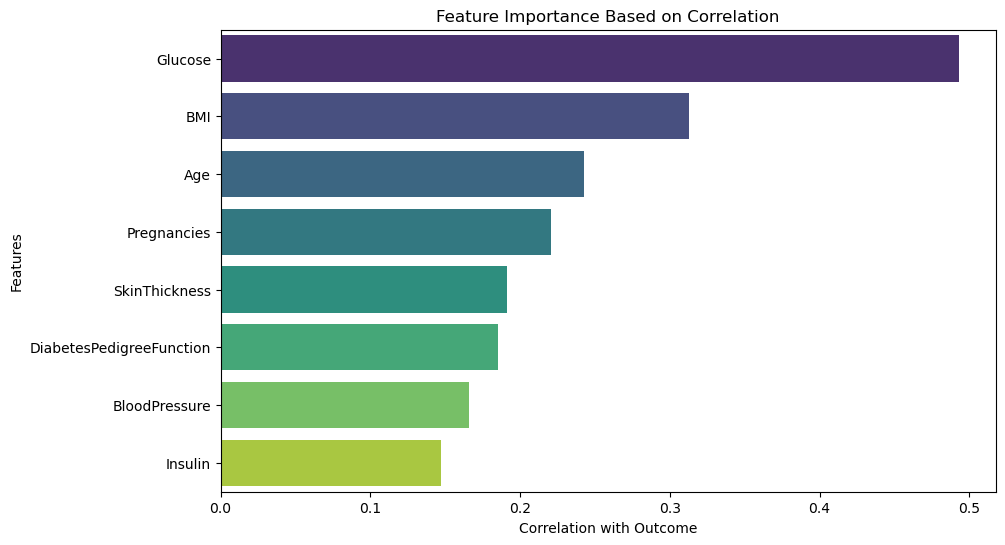

In [3]:
# Compute correlation with target variable
feature_importance = df.corr()['Outcome'].drop('Outcome').abs().sort_values(ascending=False)

# Convert Series to DataFrame
importance_df = feature_importance.reset_index()
importance_df.columns = ['Feature', 'Importance']  # Rename columns

# Display feature importance
print("Feature Importance based on Correlation:")
print(importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")

# Add labels and title
plt.xlabel("Correlation with Outcome")
plt.ylabel("Features")
plt.title("Feature Importance Based on Correlation")
plt.show()

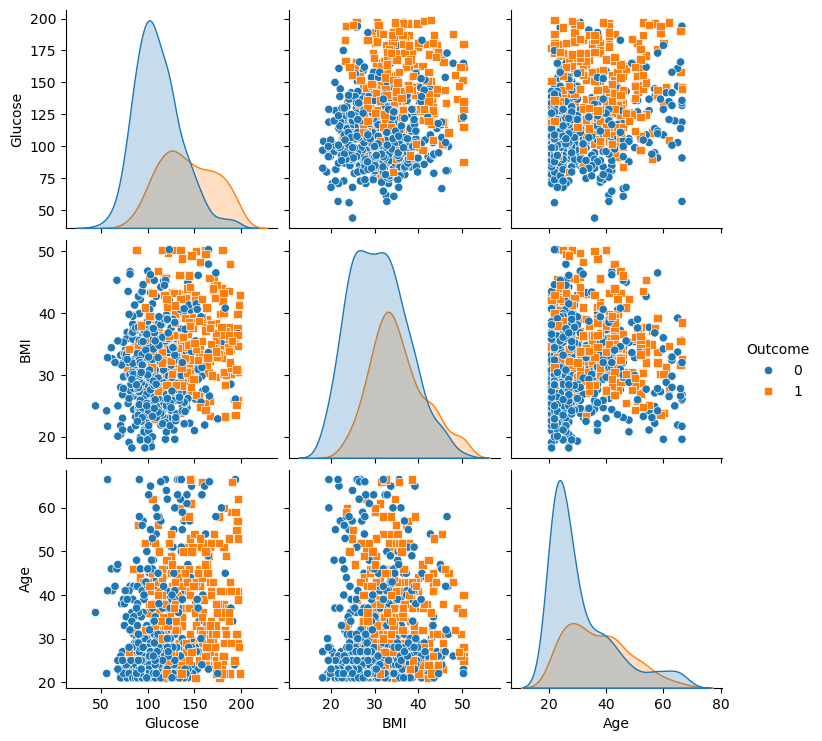

In [4]:
# analysis the first 3 categories
filter_clean_data_df = df[['Glucose', 'BMI', 'Age', 'Outcome']]
sns.pairplot(filter_clean_data_df, hue="Outcome", markers=["o", "s"], corner=False)

In [5]:
glucose_boundaries = [53, 70, 97.5, 125, 162.5, 200]
bmi_boundaries = [18, 18.5, 25, 30, 35, 40, 68]
age_boundaries = [18, 22, 43, 51, 82]

In [6]:
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.patches import Rectangle

def draw_y_lines(boundaries: list, ax: Axes):
    for boundary in boundaries:
        ax.axhline(y=boundary, linestyle='--', color='0.6')


def draw_x_lines(boundaries: list, ax: Axes):
    for boundary in boundaries:
        ax.axvline(x=boundary, linestyle='--', color='0.6')

def plot_area_matrix(
    clean_data_df: pd.DataFrame,
    x_feature: str,
    y_feature: str,
    count_feature: str,
    x_boundaries: list,
    y_boundaries: list,
    ax: Axes,
):
    draw_x_lines(boundaries=x_boundaries, ax=ax)
    draw_y_lines(boundaries=y_boundaries, ax=ax)
    sns.scatterplot(data=clean_data_df,
                    x=x_feature,
                    y=y_feature,
                    ax=ax,
                    hue=count_feature,
                    linewidth=1,
                    edgecolor='black',
                    alpha=0.7,
                    style=count_feature)

    for i in range(len(x_boundaries) - 1):
        x_left_bound = x_boundaries[i]
        x_right_bound = x_boundaries[i+1]
        for j in range(len(y_boundaries) - 1):
            y_left_bound = y_boundaries[j]
            y_right_bound = y_boundaries[j+1]
            # filtering & counting
            sub_data_df = clean_data_df[(clean_data_df[y_feature].between(y_left_bound, y_right_bound)) &
                                        (clean_data_df[x_feature].between(x_left_bound, x_right_bound))]
            total_count = sub_data_df.shape[0]
            if total_count < 1:
                continue
            count_map = sub_data_df[count_feature].value_counts()

            if total_count > 0:
                no_count = count_map[0] if 0 in count_map.index else 0
                yes_count = count_map[1] if 1 in count_map.index else 0

                o_y = y_left_bound
                o_x = x_left_bound
                rect_height = y_right_bound - o_y
                rect_width = x_right_bound - o_x

                yes_ratio = yes_count / total_count

                area_color = list(mpl.colormaps['coolwarm'](yes_ratio))
                area_color[3] = 0.8

                rect = Rectangle(
                    (o_x, o_y), rect_width, rect_height, facecolor=area_color
                )
                # label_str = f"{yes_ratio:.2f}\n0: {no_count}\n1: {yes_count}\nTotal: {total_count}"
                label_str = f"{yes_ratio:.2f}\nTotal: {total_count}"
                ax.add_patch(rect)
                ax.text(
                    x=o_x + rect_width / 2,
                    y=o_y + rect_height / 2,
                    s=label_str,
                    color='white',
                    fontsize=10,
                    ha='center',
                    va='center',
                    weight='bold',
                    path_effects=[path_effects.withStroke(linewidth=2, foreground="black")]
                )

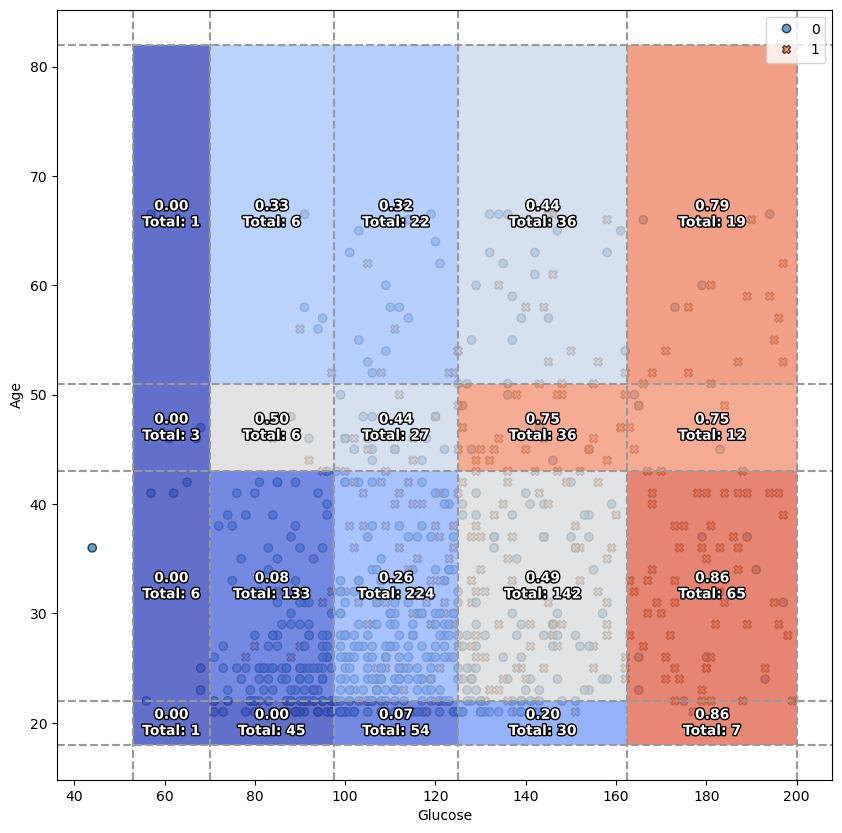

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_area_matrix(
    clean_data_df=df,
    x_feature='Glucose',
    y_feature='Age',
    count_feature='Outcome',
    x_boundaries=glucose_boundaries,
    y_boundaries=age_boundaries,
    ax=ax
)

plt.legend(loc='upper right')
plt.show()

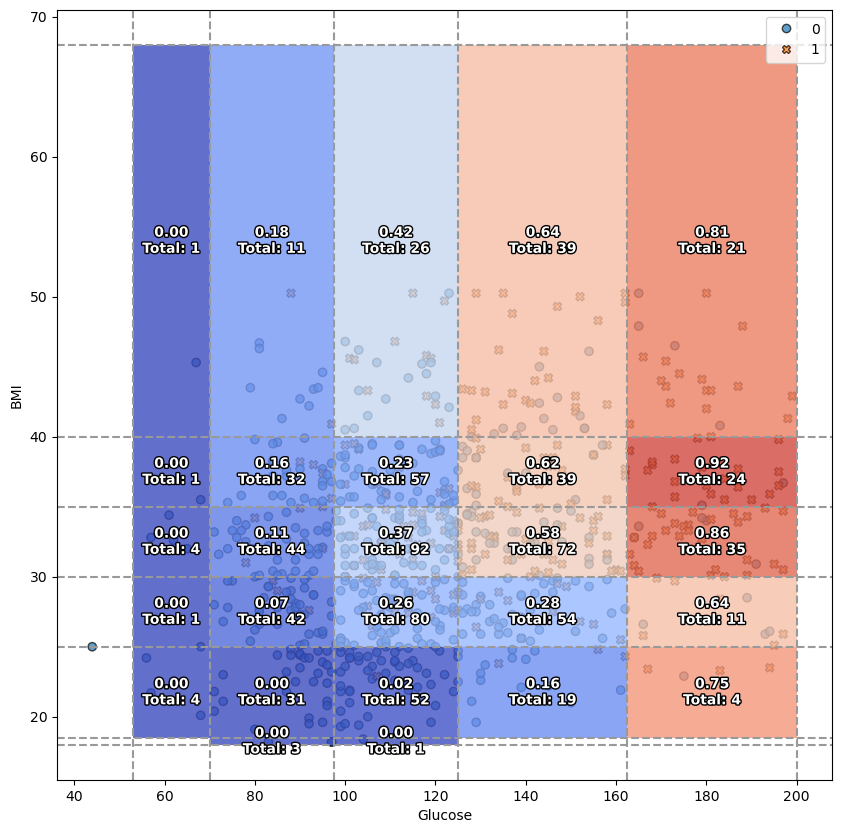

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_area_matrix(
    clean_data_df=df,
    x_feature='Glucose',
    y_feature='BMI',
    count_feature='Outcome',
    x_boundaries=glucose_boundaries,
    y_boundaries=bmi_boundaries,
    ax=ax
)

plt.legend(loc='upper right')
plt.show()

In [9]:
# Define fuzzy membership functions
def glucoseTri(glucose: ctrl.Antecedent):
    glucose['very low'] = fuzz.trapmf(glucose.universe, [0, 53, 61.5, 97.5])
    glucose['low'] = fuzz.trimf(glucose.universe, [53, 83.75, 125])
    glucose['medium'] = fuzz.trimf(glucose.universe, [70, 111.25, 162.5])
    glucose['high'] = fuzz.trimf(glucose.universe, [97.5, 143.75, 200])
    glucose['very high'] = fuzz.trapmf(glucose.universe, [125, 181.25, 200, 300])

def glucoseTrap(glucose: ctrl.Antecedent):
    glucose['very low'] = fuzz.trapmf(glucose.universe, [0, 54, 69, 97.5])
    glucose['low'] = fuzz.trapmf(glucose.universe, [53, 71, 96.5, 125])
    glucose['medium'] = fuzz.trapmf(glucose.universe, [70, 98.5, 124, 162.5])
    glucose['high'] = fuzz.trapmf(glucose.universe, [97.5, 126, 161.5, 200])
    glucose['very high'] = fuzz.trapmf(glucose.universe, [125, 163.5, 199, 300])

def ageTri(age: ctrl.Antecedent):
    age['young'] = fuzz.trapmf(age.universe, [0, 18, 20, 32.5])
    age['middle age'] = fuzz.trimf(age.universe, [20, 32.5, 47])
    age['old'] = fuzz.trimf(age.universe, [32.5, 47, 66.5])
    age['very old'] = fuzz.trapmf(age.universe, [47, 66.5, 82, 100])

def ageTrap(age: ctrl.Antecedent):
    age['young'] = fuzz.trapmf(age.universe, [0, 19, 21, 32.5])
    age['middle age'] = fuzz.trapmf(age.universe, [20, 27.25, 37.75, 47])
    age['old'] = fuzz.trapmf(age.universe, [32.5, 45, 49, 66.5])
    age['very old'] = fuzz.trapmf(age.universe, [47, 58.75, 100, 100])

def bmiTri(bmi: ctrl.Antecedent):
    bmi['underweight'] = fuzz.trapmf(bmi.universe, [0, 0, 18.25, 21.75])
    bmi['normal weight'] = fuzz.trimf(bmi.universe, [18.25, 21.75, 27.5])
    bmi['overweight'] = fuzz.trimf(bmi.universe, [21.75, 27.5, 32.5])
    bmi['obesity 1'] = fuzz.trimf(bmi.universe, [27.5, 32.5, 37.5])
    bmi['obesity 2'] = fuzz.trimf(bmi.universe, [32.5, 37.5, 42.5])
    bmi['obesity 3'] = fuzz.trapmf(bmi.universe, [37.5, 42.5, 80, 80])

def bmiTrap(bmi: ctrl.Antecedent):
    bmi['underweight'] = fuzz.trapmf(bmi.universe, [0, 18.05, 18.45, 21.75])
    bmi['normal weight'] = fuzz.trapmf(bmi.universe, [18.25, 19.15, 24.35, 27.5])
    bmi['overweight'] = fuzz.trapmf(bmi.universe, [21.75, 25.5, 29.5, 32.5])
    bmi['obesity 1'] = fuzz.trapmf(bmi.universe, [27.5, 30.5, 34.5, 37.5])
    bmi['obesity 2'] = fuzz.trapmf(bmi.universe, [32.5, 35.5, 39.5, 42.5])
    bmi['obesity 3'] = fuzz.trapmf(bmi.universe, [37.5, 40.5, 80, 80])

def predictionTri(prediction: ctrl.Antecedent):
    prediction['no'] = fuzz.trimf(prediction.universe, [0, 0, 0.8])
    prediction['yes'] = fuzz.trimf(prediction.universe, [0.2, 1, 1])

def predictionTrap(prediction: ctrl.Antecedent):
    prediction['no'] = fuzz.trapmf(prediction.universe, [0, 0, 0.2, 0.8])
    prediction['yes'] = fuzz.trapmf(prediction.universe, [0.2, 0.8, 1, 1])


In [10]:
# Define fuzzy rules
def buildRules(glucose: ctrl.Antecedent, age: ctrl.Antecedent, bmi: ctrl.Antecedent, prediction: ctrl.Consequent):
    return [
        #glucose, age => no
        ctrl.Rule(glucose['very low'] & (age['young'] | age['middle age'] | age['old'] | age['very old']), prediction['no']),
        ctrl.Rule(glucose['low'] & (age['young'] | age['middle age']), prediction['no']),
        ctrl.Rule(glucose['medium'] & (age['young'] | age['middle age'] ), prediction['no']),
        ctrl.Rule(glucose['high'] & (age['young'] ), prediction['no']),
        
        #glucose, age => yes
        ctrl.Rule(glucose['high'] & age['old'], prediction['yes']),
        ctrl.Rule(glucose['very high'] & (age['young'] | age['middle age'] | age['old'] | age['very old']), prediction['yes']),
        
        #glucose, BMI => no
        ctrl.Rule(glucose['very low'] & (bmi['normal weight'] | bmi['overweight'] | bmi['obesity 1'] | bmi['obesity 2'] | bmi['obesity 3']), prediction['no']),
        ctrl.Rule(glucose['low'] & (bmi['underweight'] | bmi['normal weight'] | bmi['overweight'] | bmi['obesity 1'] | bmi['obesity 2'] | bmi['obesity 3']), prediction['no']),
        ctrl.Rule(glucose['medium'] & (bmi['underweight'] | bmi['normal weight'] | bmi['overweight'] | bmi['obesity 2'] ), prediction['no']),
        ctrl.Rule(glucose['high'] & (bmi['normal weight'] | bmi['overweight']), prediction['no']),
        
        #glucose, BMI => yes
        ctrl.Rule(glucose['very high'] & (bmi['normal weight'] | bmi['obesity 1'] | bmi['obesity 2'] | bmi['obesity 3']), prediction['yes']),
    ]

C:\Users\USER\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


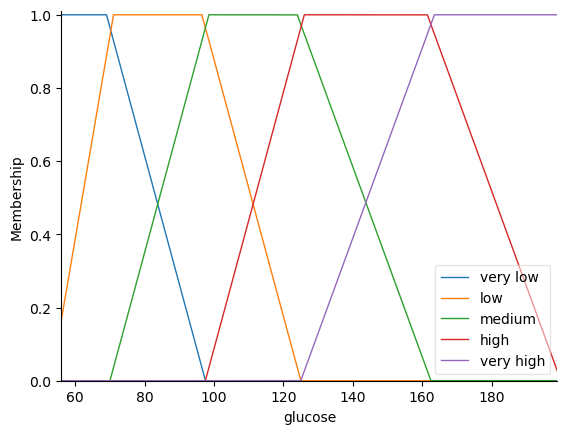

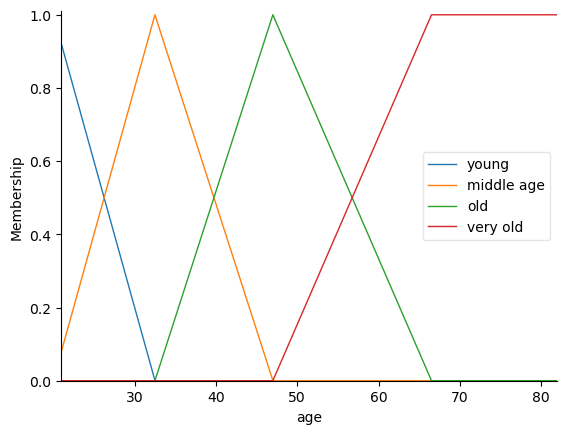

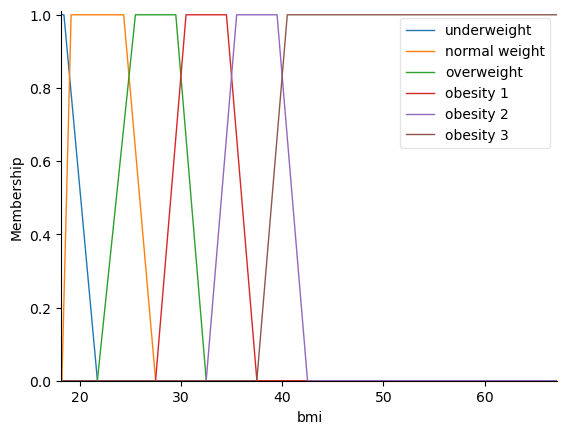

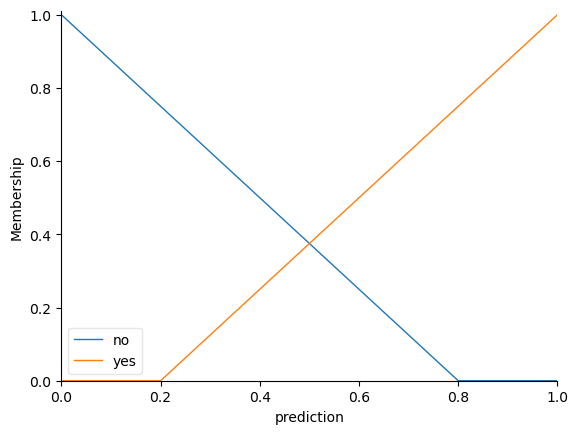

In [11]:
# Evaluate fuzzy model
# Define fuzzy variables
glucose = ctrl.Antecedent(np.arange(56, 198+1, 0.01), 'glucose')
age = ctrl.Antecedent(np.arange(21, 81+1, 0.01), 'age')
bmi = ctrl.Antecedent(np.arange(18.2, 67.1+0.1, 0.01), 'bmi')
prediction = ctrl.Consequent(np.arange(0, 1+0.05, 0.05), 'prediction', defuzzify_method="centroid")

glucoseTrap(glucose=glucose)
ageTri(age=age)
bmiTrap(bmi=bmi)
predictionTri(prediction=prediction)

rules = buildRules(glucose=glucose, age=age, bmi=bmi, prediction=prediction)

# Set up the control system
prediction_ctrl = ctrl.ControlSystem(rules)
prediction_inference = ctrl.ControlSystemSimulation(prediction_ctrl)

# Visualize fuzzy sets
glucose.view()
age.view()
bmi.view()
prediction.view()

Accuracy (Train): 0.78

Classification Report for Training Set:
              precision    recall  f1-score   support

 No Diabetes       0.77      0.93      0.84       401
    Diabetes       0.78      0.49      0.60       213

    accuracy                           0.78       614
   macro avg       0.78      0.71      0.72       614
weighted avg       0.78      0.78      0.76       614



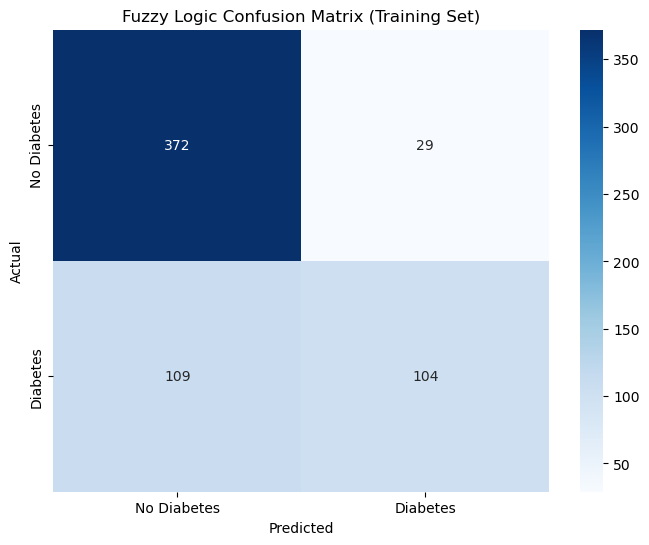

In [12]:
# Predictions for the training set
prediction_inference.input['glucose'] = X_train['Glucose'].to_numpy()
prediction_inference.input['age'] = X_train['Age'].to_numpy()
prediction_inference.input['bmi'] = X_train['BMI'].to_numpy()

# Compute the predictions for the training set
prediction_inference.compute()
result_train_np = prediction_inference.output['prediction']

# Convert the fuzzy output to binary classification
output_train_np = np.where(result_train_np > 0.50, 1, 0)
gt_train_np = y_train.to_numpy()

# Calculate accuracy for training set
accuracy_train = accuracy_score(gt_train_np, output_train_np)

# Print accuracy for training set
print(f"Accuracy (Train): {accuracy_train:.2f}")

# Generate classification report for training set
print("\nClassification Report for Training Set:")
print(classification_report(gt_train_np, output_train_np, target_names=['No Diabetes', 'Diabetes']))

# Compute the confusion matrix for the training set
conf_matrix_train = confusion_matrix(gt_train_np, output_train_np)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Fuzzy Logic Confusion Matrix (Training Set)")
plt.show()

Accuracy (Test): 0.77

Classification Report for Testing Set:
              precision    recall  f1-score   support

 No Diabetes       0.78      0.89      0.83        99
    Diabetes       0.73      0.55      0.62        55

    accuracy                           0.77       154
   macro avg       0.76      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154



C:\Users\USER\anaconda3\Lib\site-packages\skfuzzy\control\controlsystem.py:182: UserWarning: Input array is shape (154,), which is different from previous array(s) which were (614,).  This may cause problems, unless you are replacing all inputs.
  warn("Input array is shape {0}, which is different "


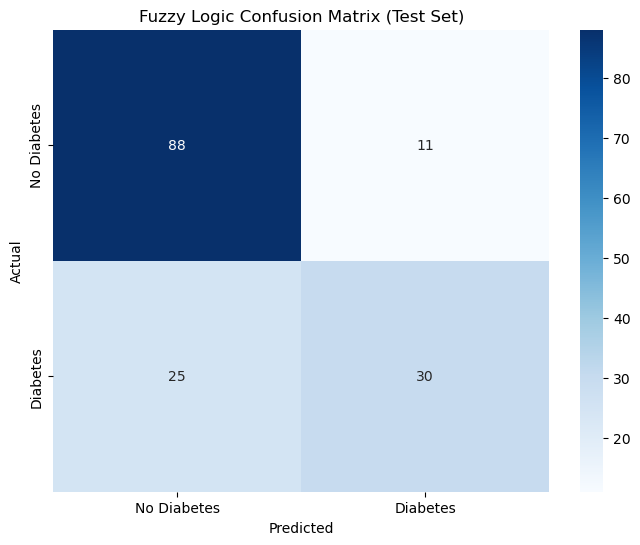

In [13]:
# Predictions for the test set
prediction_inference.input['glucose'] = X_test['Glucose'].to_numpy()
prediction_inference.input['age'] = X_test['Age'].to_numpy()
prediction_inference.input['bmi'] = X_test['BMI'].to_numpy()

# Compute the predictions for the test set
prediction_inference.compute()
result_np = prediction_inference.output['prediction']

# Convert the fuzzy output to binary classification
output_np = np.where(result_np > 0.50, 1, 0)
gt_np = y_test.to_numpy()

# Calculate accuracy for test set
accuracy_test = accuracy_score(gt_np, output_np)

# Print accuracy for test set
print(f"Accuracy (Test): {accuracy_test:.2f}")

# Generate classification report for test set
print("\nClassification Report for Testing Set:")
print(classification_report(gt_np, output_np, target_names=['No Diabetes', 'Diabetes']))

# Compute the confusion matrix for the test set
conf_matrix_test = confusion_matrix(gt_np, output_np)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Fuzzy Logic Confusion Matrix (Test Set)")
plt.show()